In [1]:
import os
import datetime
# Local Imports
from src.coastseg import coastseg_logs #must be the first module loaded to create logs folder
from src.coastseg import coastseg_map

# External Imports
import ee
from google.auth import exceptions as google_auth_exceptions
from IPython.display import display, clear_output
from tkinter import Tk,filedialog
from ipywidgets import Button, HBox, VBox, Layout, DatePicker, HTML, RadioButtons, SelectMultiple, Output, Checkbox

# suppress tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# root = Tk()
remove_style=dict(button_color = 'red')
load_style=dict(button_color = '#69add1')
action_style=dict(button_color = '#ae3cf0')
save_style=dict(button_color = '#50bf8f')

In [ ]:
import geopandas as gpd

In [ ]:
# type(gpd.GeoDataFrame()) == 'geopandas.geodataframe.GeoDataFrame'

## Authenticate and Initialize with Google Earth Engine (GEE)

- Run this cell to initialize with GEE which will allow you to download remote sensing data from GEE.

### First Time Users

- In order to use Google Earth Engine (GEE) you will need to sign up to request access to use Google Earth Engine.https://signup.earthengine.google.com. You will only need to do this once and it takes only a day to get your account verified.

### How `ee.Authenticate()` works

- In order to initialize with GEE you will need an authorization token with is obtained by running `ee.Authenticate()`.This token lasts 7 days and during those 7 days you will not need to authenticate with google earth engine with an access code. Once the 7 days are up you will need to reauthenticate to use GEE again.


In [2]:
try:
    ee.Initialize()
except google_auth_exceptions.RefreshError as exception:
    print("Please authenticate with Google:\n")
    ee.Authenticate()
    ee.Initialize()

In [3]:
# Date Widgets
start_date=DatePicker(
    description='Start Date',
    value=datetime.date(2018, 12, 1),
    disabled=False,
)
end_date=DatePicker(
    description='End Date',
    value=datetime.date(2019, 3, 1), #2019, 1, 1
    disabled=False,
)
date_instr=HTML(
    value="<b>Pick a date:</b>",
    layout=Layout(padding='10px')
)
dates_box=HBox([start_date,end_date])
dates_vbox=VBox([date_instr,dates_box])


collection_instr=HTML(
    value="<b>Pick a collection</b>\
        <br> C01: LandSat Collection 1 \
        <br> C02: LandSat Collection 2  [2022/01/01 and beyond] \
        <br>      - Landsat 9 is only available in C02",
    layout=Layout(padding='10px')
)
collection_radio=RadioButtons(
    options=['C01', 'C02'],
    value='C01',
    description='Collection:',
    disabled=False
)
collection_vbox=VBox([collection_instr,collection_radio])

sat_instr=HTML(
    value="<b>Pick multiple satellites by holding the control key:</b> \
        <br> - images prior to 2022/01/01 will be downloaded from Collection 1 \
        <br> - images after 2022/01/01 will be automatically downloaded from Collection 2 \
        <br> C01: LandSat Collection 1 : All dates before 2022/01/01\
        <br> C02: LandSat Collection 2 : All dates after 2022/01/01 \
        <br> - Landsat 9 is only available in C02",
    layout=Layout(padding='10px')
)


satellite_selection=SelectMultiple(
    options=['L5', 'L7', 'L8', 'S2'],
    value=['L8'],
    description='Satellites',
    disabled=False
)
sat_vbox = VBox([sat_instr,satellite_selection])

def handle_collection_change(change):
    if change['new'] == 'C02':
        satellite_selection.options=['L5', 'L7', 'L8', 'L9', 'S2']
    else:
        satellite_selection.options=['L5', 'L7', 'L8', 'S2']

collection_radio.observe(handle_collection_change,"value")

controls_vbox=VBox([dates_vbox, collection_vbox, sat_vbox])
controls_vbox

In [4]:
# CoastSat Download Variables
# ------------------------------
# Save the satellites selected to sat_list
if satellite_selection.value:
    sat_list = list(satellite_selection.value)
elif not satellite_selection.value:
    print("ERROR: You must select at least one satellite first")
# Save the dates selected by the user as well as the selected collection
dates = [str(start_date.value),str(end_date.value)]
collection = collection_radio.value
print(f"dates: {dates}")
print(f"collection: {collection}")
print(f"sat_list: {sat_list}")

dates: ['2018-12-01', '2019-03-01']
collection: C01
sat_list: ['L8']


## Settings for CoastSat

Modify any of the following setting to determine how data is downloaded from CoastSat


In [5]:
pre_process_settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
     'dist_clouds': 300,        # ditance around clouds where shoreline can't be mapped
    'output_epsg': 3857,        # epsg code of spatial reference system desired for the output   
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 4500,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 150,         # radius (in metres) of the buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 200,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off':'False',          # if True, no pan-sharpening is performed on Landsat 7,8 and 9 imagery
    'create_plot':False,        # True create a matplotlib plot of the image with the datetime as the title
}

# Create the Map

- Create the map object here
- Save all the settings created earlier
- Save the list of satellites, dates, and the collection to coastseg_map instance


In [6]:
coastseg_map=coastseg_map.CoastSeg_Map()

In [7]:
coastseg_map.set_sat_list(sat_list)
coastseg_map.set_collection(collection)
coastseg_map.set_dates(dates)
coastseg_map.set_preprocess_settings(pre_process_settings)

In [9]:
# var=None
# if type(var) == type(gpd.GeoDataFrame()):
#     print(var)

# How to Use The Map

---

1. Use the rectangle tool to draw a bounding box along the coastline.
2. Click `Generate ROI` to create ROI rectangles along the coastline in the bounding box. This may take some time.

- You should see a coastline appear in yellow and some rectangles along it.

3. Click 1 or more ROIs then click `Save ROI` to save these ROIs for downloading later
4. You're ready to download the ROIs. Run the next block of code.


In [10]:
from src.coastseg.UI_map import UI
coastseg_ui = UI(coastseg_map)
coastseg_ui.create_dashboard()

In [13]:
coastseg_map.bbox.gdf

,geometry
0,"POLYGON ((-121.57720 36.00921, -121.57720 36.0..."


In [18]:
import geopandas as gpd
import json
from shapely.geometry import Polygon
def convert_roi_to_polygon(rois_gdf:gpd.geodataframe,id:str=None)->Polygon:
    """Returns the roi with given id as Shapely.Polygon
    Args:
        rois_gdf (gpd.geodataframe): geodataframe with all rois
        id (str): roi_id
    Returns:
        Polygon: roi with the id converted to Shapely.Polygon
    """
    if id is None:
        single_roi=rois_gdf
    else:
        # Select a single roi
        single_roi = rois_gdf[rois_gdf['id']==id]
    single_roi=single_roi["geometry"].to_json()
    single_roi = json.loads(single_roi)
    poly_roi = Polygon(single_roi["features"][0]["geometry"]['coordinates'][0])
    return poly_roi

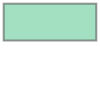

In [20]:
poly_roi = convert_roi_to_polygon(coastseg_map.bbox.gdf)
poly_roi

In [21]:
type(poly_roi)

shapely.geometry.polygon.Polygon

## Run Models on Imagery
1. Select if you want to use a GPU or not. By default you won't your computer's GPU
2. Select if you want to use CRF post-processing or not. By default CRF post-processing is not enabled
<br>**WARNING**: There is a bug with CRF post-processing and the models so you will need to enable CRF post-processing until it is fixed.
3. Select whether your data is the type RGB or MNDWI
4. Select the model you want to use
5. Select Ensemble or Best (Ensemble is recommended) 
6. 


In [ ]:
from src.coastseg.UI_models import UI_Models
models_ui = UI_Models()
models_ui.create_dashboard()